This notebook performs Exploratory Data Analysis on the dataset used in the modelling process.


## Imports

In [8]:
# This notebook is typically run on Google Colab, where it is necessary to mount the directory in GoogleDrive from which we work
# if it is not being run on colab then we skip past these lines.

try:
  from google.colab import drive
  drive.mount('/content/Drive')
  import sys
  sys.path.append('/content/Drive/Shareddrives/Thesis/Regression') # Updating our path to import drom drive
except:
  pass

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


In [9]:
# Importing the required Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import ThesisUtils as tu
import statsmodels.api as sm
import datetime

# Setting the dimensions of plots and diagrams used in this notebook to 10 x 4

sns.set(rc={'figure.figsize': (10, 4)})

In [53]:

# The dataset is saved on my public github repository

# Importing the historical data back to 2017-09-11 to 2021-10-21 at 7am.

asset = "BTC" # Choice of "BTC" for bitcoin and "ETH" for Ethereum
url = 'https://raw.githubusercontent.com/david-mannion/Thesis/main/{}_Updated.csv'.format(asset)
h_data = tu.load_dataset(url)
h_data = h_data[["Last", "Volume"]]
h_data.columns = ["Close","Volume"]
h_data.index.names = ['Datetime']

In [54]:
# Verifying the data has been imported correctly.
h_data

,Close,Volume
Datetime,,
2017-09-11 00:00:00,4176.30,0.0
2017-09-11 00:30:00,4157.48,0.0
2017-09-11 01:00:00,4208.83,0.0
2017-09-11 01:30:00,4171.88,0.0
2017-09-11 02:00:00,4187.58,0.0
...,...,...
2021-10-21 05:00:00,66134.11,631.0
2021-10-21 05:30:00,65661.25,628.0
2021-10-21 06:00:00,65937.77,615.0


In [77]:
# The data provider (Barchart.com) of the CSVs have a time lag of 4 hours, so if we actually want to use this data to trade real life data
# We need to combine this data with a different sourc that has a lot lower lag
# Fortunately, Yahoo Finance provides 30min data with a lag of only 1 minute which we deem acceptable
# Further developments to this model could include using the Binance API which has a shorter time lag than this

if asset == "BTC" or asset == "ETH":
  asset = asset + "-USD"

try:
  import yfinance as yf
  ticker = yf.Ticker(asset)
  # get historical market data
  yf_data = ticker.history(start = "2021-08-23", interval = "30m")
  yf_data.index = yf_data.index.tz_localize(None)
  yf_data["Volume"] = yf_data["Volume"]/1000000
except:
  !pip install yfinance --upgrade --no-cache-dir
  import yfinance as yf
  ticker = yf.Ticker(asset)
  #get historical market data
  yf_data = ticker.history(start = "2021-08-23", interval = "30m") # Data can only go back 60 days with a 30 minute interval
  yf_data.index = yf_data.index.tz_localize(None)
  yf_data["Volume"] = yf_data["Volume"]/1000000 # Here we scale the volume as the data from barchart is volume/1000000. Using a smaller number is more memory efficient too.

In [149]:
yf_data = yf_data[["Close","Volume"]] # Taking only the necessary columns from the Yahoo Finance data
data = pd.concat([h_data, yf_data[yf_data.index>h_data.index[-1]]]) # Joining the data from the CSV with the more up to date Yahoo! Finance data

In [150]:
# Checking for NAs
data.isna().sum()

Close     140
Volume    140
dtype: int64

In [151]:
# We see there are some columns that have NA values
# The best way to deal with these is by removing the NAs using a moving average

count = 0
while data.isna().sum()[0] > 0 and count < 100:
  data.Close = data.Close.fillna(data.Close.rolling(4, min_periods = 1).mean())
  data.Volume = data.Volume.fillna(data.Volume.rolling(4, min_periods = 1).mean())
  count += 1

In [152]:
data.isna().sum()

# We see the NAs are now gone

Close     0
Volume    0
dtype: int64

In [ ]:
# Write the dataset to a csv file

data.to_csv("/content/Drive/Shareddrives/Thesis/Trading/Datasets/data_cleaned.csv")

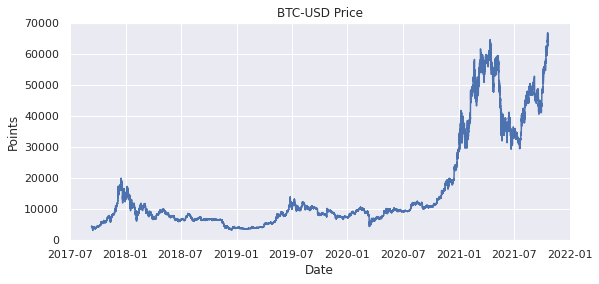

In [153]:
# We visulaize the data to get an idea of what were working with while also helping to verify the data has been imported correctly

plt.plot(data.Close)
plt.title("{} Price".format(asset))
plt.ylabel("Points")
plt.xlabel("Date")
plt.show()
#plt.savefig("/content/Drive/Shareddrives/Thesis/Trading/eda/FTSE100price.jpg")

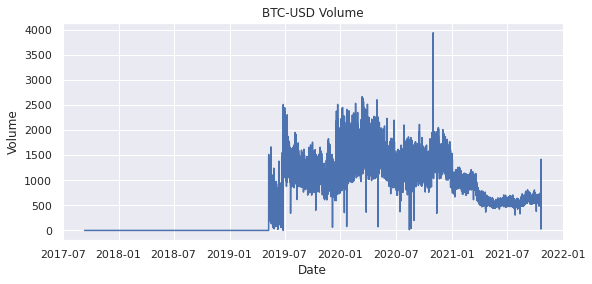

In [154]:
# Here we plot the volume for similar reasons to above.
# We can see volume is zero until May 2019, this will have to be considered when performing the modelling

#plt.plot(data.Volume[data.Volume.values > 0])
plt.plot(data.Volume)
plt.title("{} Volume".format(asset))
plt.ylabel("Volume")
plt.xlabel("Date")
plt.show()
#plt.savefig("/content/Drive/Shareddrives/Thesis/Regression/eda/FTSE100Volume.jpg")


Note that the price data goes back to late 2017 but we only have volume data from mid 2019 onwards.


In [155]:
# The returns function finds the % change from one period to another 

importlib.reload(tu)
returns = tu.returns(data.Close)

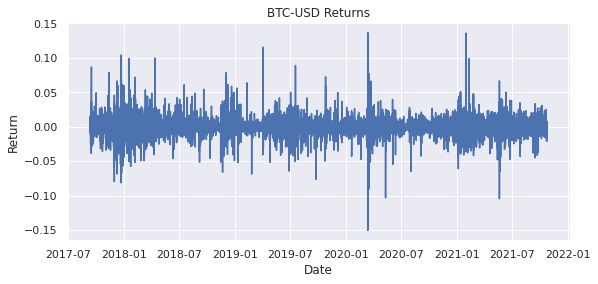

In [169]:
# Plotting the returns

plt.plot(returns)
plt.title("{} Returns".format(asset))
plt.ylabel("Return")
plt.xlabel("Date")
plt.show()

#plt.savefig("/content/Drive/Shareddrives/Thesis/Regression/eda/FTSE100Retuns.jpg")

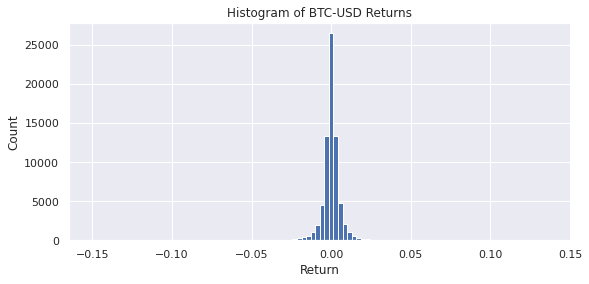

In [171]:
# Plotting a histogram of the distribution of returns. 
# Returns should resemble some sort of normal distribution

plt.hist(returns, bins = 100)
plt.title("Histogram of {} Returns".format(asset))
plt.ylabel("Count")
plt.xlabel("Return")
plt.show()
#plt.savefig("/content/Drive/Shareddrives/Thesis/Regression/eda/FTSE100returnshist.jpg")

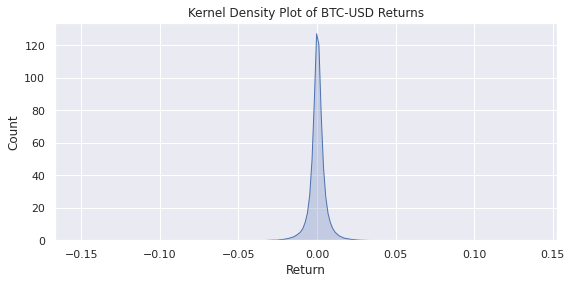

In [172]:
# Density plot of returns

sns.kdeplot(returns, shade = True)
plt.title("Kernel Density Plot of {} Returns".format(asset))
plt.ylabel("Count")
plt.xlabel("Return")
plt.show()

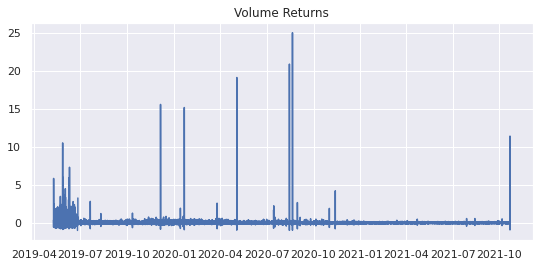

In [173]:
# Finding volume returns here.
# Typically not used but I found it to be a useful feature in later analysis once some more transformations have been applied so I include it here

vol_returns = tu.returns(data.Volume)
plt.title("Volume Returns")
plt.plot(vol_returns)
plt.show()

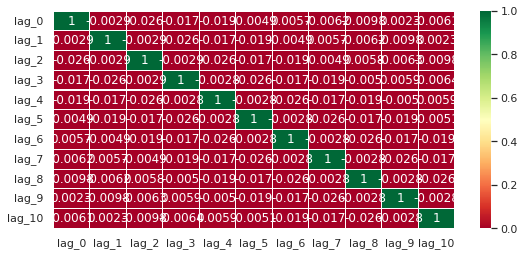

In [174]:
# Making a correlation plot for 10 time lags of return
# Helpful to get an idea of the nature of the data and if any relationships can be seen between variables
# We see low correlation between each lag, suggesting there is no strong autocorrelation between lags

lags = tu.lagged_df(returns, num_of_lags = 10)
sns.heatmap(lags.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)
plt.show()

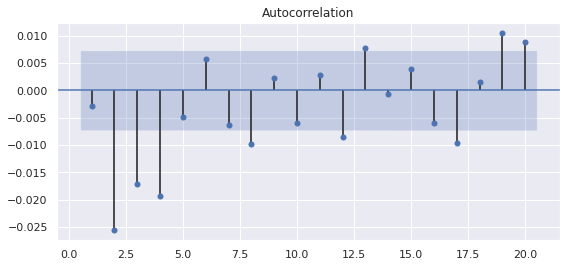

In [161]:
# An ACF plot visualizes the correlation between lags, with the blue showing the confidence interval for significant lags.
# It appears lag 2,3,4 8,12,19 and 20 are significant suggesting some autocorrelation between varibles

sm.graphics.tsa.plot_acf(returns.squeeze(), lags = 20, zero = False)
plt.savefig("/content/Drive/Shareddrives/Thesis/Regression/eda/FTSE100acf.jpg")

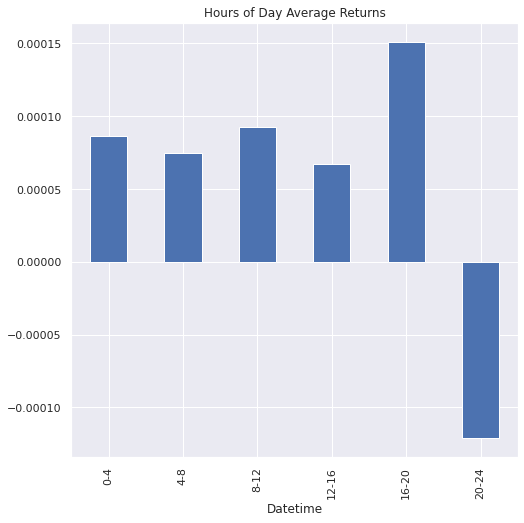

In [163]:
# Investigating whether the time of day effects returns.
# We see, on average that returns are positive except for 8-12pm when they are on average negative

importlib.reload(tu)
tu.visualize(returns, xlim=(-1, 1), kind ="time_bar")

In [175]:
# Getting a numerical representation of the graphic above
# This shows that on average, between 4-8pm Bitcoin shows a positive return while from 8-12 shows a negative return

tu.visualize(returns, xlim=(-1, 1), kind ="time_mean")

,lag_0
Datetime,
0-4,0.000087
4-8,0.000075
8-12,0.000093
12-16,0.000067
16-20,0.000151
20-24,-0.000121


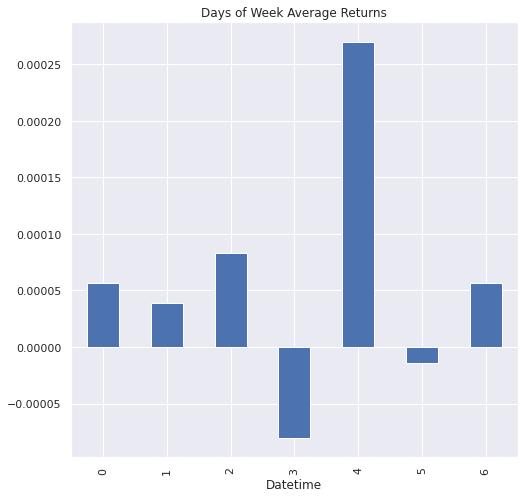

In [165]:
# Doing the same for the day of the week, we see day 4(Friday) shows the highest average return while Day 3(Thursday) shows an average negative return


tu.visualize(returns, xlim=(-0.05, 0.05), kind ="bar")

In [166]:
# Getting a numerical representation of the graphic above

tu.visualize(returns, xlim=(-1, 1), kind ="mean")


,lag_0
Datetime,
0,0.000057
1,0.000039
2,0.000083
3,-0.000080
4,0.000269
5,-0.000014
6,0.000056
